In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import dirichlet, poisson, norm
from scipy.special import factorial, logsumexp
import statsmodels.api as sm
import matplotx
from multiprocessing import Pool
from time import time
from tqdm import tqdm

plt.style.use(matplotx.styles.aura["dark"])

In [2]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i + 1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w


colors = ["tab:red", "tab:blue"]

In [3]:
files = ["test_data_acc_ind_492_0607.pickle", 'test_data_dms_ind_492_0603.pickle']
with open(files[0], "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'pos', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


In [61]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero((data["currMaze"] > 7) * (data["laserON"] == 0))[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
sp_filt_len = 20
bin_size = 0.05
n_neurons = 2
# neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)
neuron_idx = np.array([73, 70])
trial_id = (
    []
)  # this will keep track of each trial in the design matrix (since each trial spans multiple rows)
for i, neuron in enumerate(neuron_idx):
    X = []
    y = []
    bin_centers_all = []

    for trial_idx in trial_indices:
        keyframes = data["keyFrames"][trial_idx]
        keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
        trial_start = data["trialStart"][trial_idx]
        # trial_end = data["trialEnd"][trial_idx]
        # lcue_times = data["cueOnset_L"][trial_idx]
        # rcue_times = data["cueOnset_R"][trial_idx]
        # trial_start = keyframe_times[0] + data["trialStart"][trial_idx]
        trial_end = keyframe_times[2] + trial_start
        lcue_times = data["cueOnset_L"][
            trial_idx
        ]  # - keyframe_times[0] # remove keyframe subtraction if using all phases of trial
        rcue_times = data["cueOnset_R"][trial_idx]  # - keyframe_times[0]

        trial_length = trial_end - trial_start
        spikes = data["spikes"][neuron]
        spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]

        bins = np.arange(0, trial_length, bin_size)
        bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")
        bin_centers_all.append(bin_centers)

        time = data["time"][trial_idx][:, np.newaxis]
        pos = data["pos"][trial_idx][:, 1]
        bin_centers = bin_centers.reshape(-1, 1)
        dist = time[: pos.size].T - bin_centers
        bin_time_index = np.argmin(np.abs(dist), axis=1)
        binned_pos = pos[bin_time_index]
        # bin_positions.append(binned_pos)
        means = np.linspace(0, 275, 10)
        pos_gauss = []
        for mu in means:
            dist = norm(mu, 10)
            pos_gauss.append(dist.pdf(binned_pos))
        pos_gauss = np.array(pos_gauss)

        binned_stimr, _ = np.histogram(rcue_times, bins)
        binned_stiml, _ = np.histogram(lcue_times, bins)
        binned_spikes, _ = np.histogram(spikes - trial_start, bins)
        binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

        padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
        X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
        padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
        X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
        padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
        X_ev = hankel(padded_ev[: -filt_len + 1], padded_ev[-filt_len:])

        padded_spikes = np.pad(binned_spikes[:-1], (sp_filt_len, 0), constant_values=(0, 0))
        X_sp = hankel(padded_spikes[: -sp_filt_len + 1], padded_spikes[-sp_filt_len:])

        trial_type = data["trialType"][trial_idx]
        # X_pos = np.hstack((trial_type * pos_gauss.T, (1 - trial_type) * pos_gauss.T))
        X_pos = pos_gauss.T
        # need to add second pos matrix for choice or evidence
        X.append(np.hstack((X_sr, X_sl, X_pos, np.ones((X_sp.shape[0], 1)))))
        # X.append(np.hstack((X_sr, X_sl, np.ones((X_sp.shape[0], 1)))))

        y.append(binned_spikes[:, np.newaxis])
        if i == 0:
            trial_id.append(trial_idx * np.ones(X_sr.shape[0]))

    X_all.append(np.vstack(X))
    y_all.append(np.vstack(y))

trial_id = np.concatenate(trial_id)
X_all = np.array(X_all)
y_all = np.array(y_all)
print(y_all.shape, X_all.shape)
neuron_idx

number of trials: 210
(2, 35483, 1) (2, 35483, 71)


array([73, 70])

In [62]:
# initial glm with no states to estimate weights
theta_init = np.empty((X_all[0].shape[1], n_neurons))
# glms = [None for _ in range(n_neurons)]
sta = (X_all.transpose(0, 2, 1) @ y_all).squeeze() / y_all.sum(axis=1)

for neuron in range(n_neurons):
    # print(X_all[neuron].shape, y_all[neuron].shape, sta[neuron].shape)
    glm = sm.GLM(
        endog=y_all[neuron].squeeze(), exog=X_all[neuron], family=sm.families.Poisson()
    )
    # glms[neuron] = glm
    a = 0.1 * np.ones(X_all.shape[2])
    a[-1] = 0.00001
    res = glm.fit_regularized(alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)
    # res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
    w = res.params
    theta_init[:, neuron] = w
# print(a.shape)

100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Text(0, 0.5, '$\\gamma \\cdot log(p(y | X, Z))$')

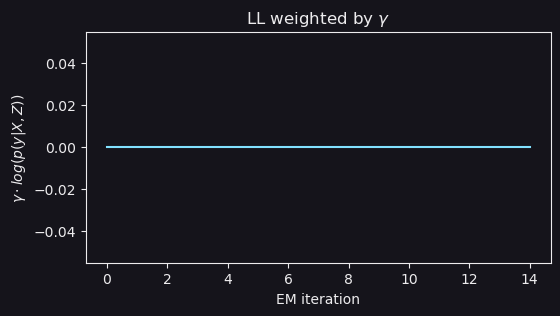

In [63]:
# with functions
n_states = 1
n_trials = trial_indices.size
theta_hmm = np.ones((n_states, X_all.shape[2], n_neurons)) * theta_init
# adding noise to all the weights
theta_hmm += np.random.normal(0, 0.1, size=theta_hmm.shape)
t_init = np.array([5, 1, 1, 1, 1])
# placing higher bias on self-transition
T = np.array(
    [dirichlet(np.roll(t_init[:n_states], n)).rvs()[0] for n in range(n_states)]
)
T = np.log(T)
pi = np.log(np.ones(n_states)) - np.log(n_states)
xi = np.empty((n_trials - 1, n_states, n_states))
scale = np.empty(n_trials)
total_ll = []


def get_poiss_ll(X, y, theta):
    v = X @ theta
    r = np.exp(v)
    ll = y * np.log(r) - r
    ll = ll.sum(axis=(0, 1))
    return ll - logsumexp(ll)


def forward(X, y, theta, T, pi, trial_id):
    n_trials = np.unique(trial_id).size
    n_states = theta.shape[0]
    alpha = np.empty((n_states, n_trials))
    predict = np.empty(alpha.shape)
    loglikeli = np.empty(alpha.shape)

    for t in range(n_trials):
        x_idx = np.argwhere(trial_id == t).squeeze()
        # predict
        if t == 0:
            predict[:, t] = pi
        else:
            pred = []
            for tran in T.T:
                pred.append(logsumexp(tran + alpha[:, t - 1]))
            predict[:, t] = np.array(pred)

        loglikeli[:, t] = get_poiss_ll(
            X[:, x_idx], y[:, x_idx], theta_hmm.transpose(2, 1, 0)
        )
        # update
        update = loglikeli[:, t] + predict[:, t]
        scale[t] = logsumexp(update)
        update -= scale[t]
        alpha[:, t] = update

    return alpha, loglikeli, scale, predict


for _ in tqdm(range(15)):
    alpha, loglikeli, scale, predict = forward(X_all, y_all, theta_hmm, T, pi, trial_id)

    beta = np.empty(alpha.shape)
    beta[:, -1] = 0  # in log form
    for t in range(n_trials - 2, -1, -1):
        b_up = []
        for tran in T:
            beta_update = tran + beta[:, t + 1] + loglikeli[:, t + 1]
            b_up.append(logsumexp(beta_update))
        beta[:, t] = np.array(b_up) - scale[t + 1]
    gamma = alpha + beta
    gamma -= logsumexp(gamma, axis=0)

    total_ll.append((np.exp(gamma) * loglikeli).sum())

    for t in range(0, n_trials - 1):
        for s1 in range(n_states):
            for s2 in range(n_states):
                xi[t, s1, s2] = (
                    T[s1, s2] + alpha[s1, t] + loglikeli[s2, t + 1] + beta[s2, t + 1]
                )

        xi[t] -= logsumexp(xi[t])

    T = logsumexp(xi, axis=0)
    T -= logsumexp(T, axis=1)[:, None]

    _, trial_counts = np.unique(trial_id, return_counts=True)
    pi = gamma[:, 0]

    # maximization
    for s in range(n_states):
        for neuron in range(n_neurons):
            weights = np.repeat(np.exp(gamma[s]), trial_counts)
            glm = sm.GLM(
                endog=y_all[neuron],
                exog=X_all[neuron],
                family=sm.families.Poisson(),
                freq_weights=weights,
            )
            # can greatly effect outcome. too high on simulated data made it fail, basically comes down to noise level of data
            # higher noise ---> set alpha to be higher
            a = 0.1 * np.ones(X_all.shape[2])
            a[-1] = 0.0001
            res = glm.fit_regularized(alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

            w = res.params
            theta_hmm[s, :, neuron] = w

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(np.array(total_ll))
ax.set_title(r"LL weighted by $\gamma$")
ax.set_xlabel("EM iteration")
ax.set_ylabel(r"$\gamma \cdot log(p(y | X, Z))$")

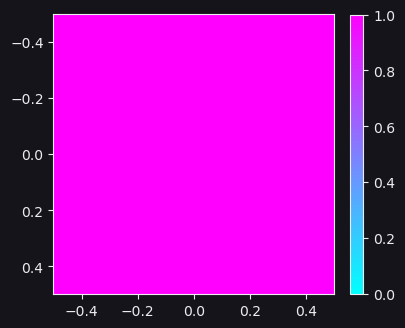

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(np.exp(T), cmap="cool", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, fraction=0.045)

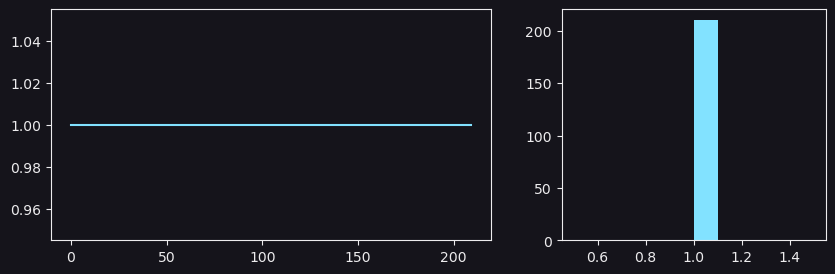

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={"width_ratios": (5, 3)})
axs[0].plot(np.exp(gamma.T)[:])
axs[1].hist(np.exp(gamma.T), label=[f"state {i}" for i in range(n_states)])
state = np.argmax(np.exp(gamma), axis=0)

IndexError: index 2 is out of bounds for axis 2 with size 2

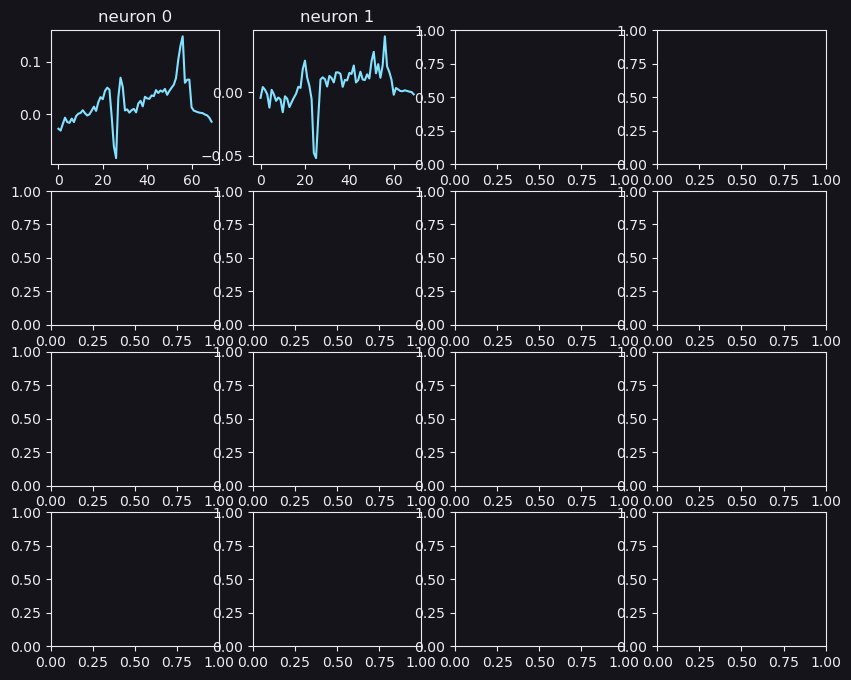

In [70]:
fig, axs = plt.subplots(4, 4, figsize=(10, 8))

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.plot(theta_hmm[:, :-1, i].T)
    ax.set_title(f"neuron {i}")
plt.suptitle("Weights")
plt.tight_layout()



In [226]:
theta_post = np.ones((n_states, X_all.shape[2], n_neurons))
for s in range(n_states):
    for neuron in range(n_neurons):
        weights = np.repeat(np.exp(gamma[s]), trial_counts)
        glm = sm.GLM(
            endog=y_all[neuron],
            exog=X_all[neuron],
            family=sm.families.Poisson(),
            freq_weights=weights,
        )
        # can greatly effect outcome. too high on simulated data made it fail, basically comes down to noise level of data
        # higher noise ---> set alpha to be higher
        a = 0.5 * np.ones(X_all.shape[2])
        a[-1] = 0.01
        res = glm.fit_regularized(alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

        w = res.params
        theta_post[s, :, neuron] = w

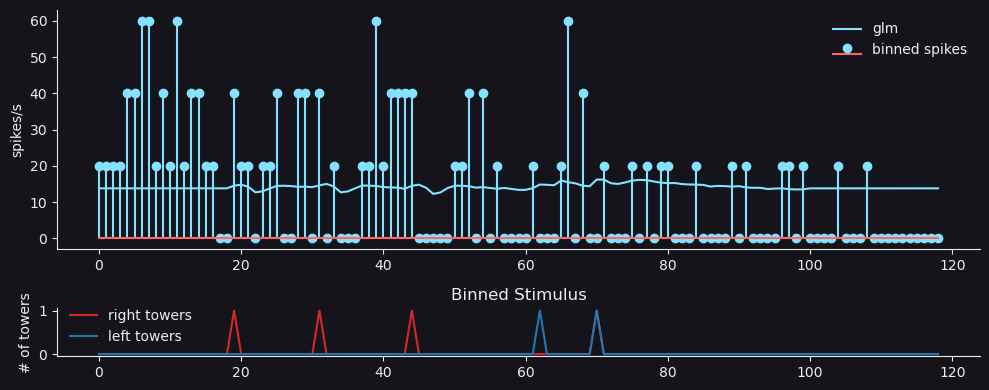

In [67]:
# fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})

# sort_idx = np.argsort(
#     data["nCues_RminusL"]
# )  # ordered index of (lots of left cues) -> (lots of right cues)
# plot_trial = sort_idx[100]
# neuron = 0
# X_plot = X_all[neuron, trial_id == plot_trial]
# # y_pred = np.exp(X_plot @ theta_init[:, neuron])
# y_pred = np.exp(X_plot @ theta_hmm[:, :, neuron].T)

# # y_pred = np.exp(X_plot @ theta_post[:, :, neuron].T)

# y_plot = y_all[neuron, trial_id == plot_trial]
# axs[0].stem(y_plot, label="binned spikes")
# axs[0].plot(y_pred, label=[f"state {i}" for i in range(n_states)])
# # trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
# axs[0].set_ylabel("spikes/bin")
# axs[0].legend()


# # axs[1].plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
# # axs[1].plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
# # trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
# # axs[1].set_ylabel("# of towers")
# # axs[1].set_title("Binned Stimulus")
# # axs[1].legend()
# # plt.tight_layout()
# sns.despine()
# print(f"gamma for selected trial {np.exp(gamma[:, plot_trial])}")
neuron = 0
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})

sort_idx = np.argsort(
    data["nCues_RminusL"]
)  # ordered index of (lots of left cues) -> (lots of right cues)
sort_idx = sort_idx[(data["currMaze"][sort_idx] > 7) * (data["laserON"][sort_idx] == 0)]
plot_trial = sort_idx[-100]
X_plot = X_all[neuron, trial_id == plot_trial]
# y_pred = np.exp(X_plot @ theta_init[:, neuron])
y_pred = np.exp(X_plot @ theta_hmm[:, :, neuron].T)

# y_pred = np.exp(X_plot @ theta_post[:, :, neuron].T)

y_plot = y_all[neuron, trial_id == plot_trial] 

# t = bin_centers_all[np.nonzero(np.unique(trial_id) == plot_trial)[0][0]]
axs[0].stem(y_plot/bin_size, label="binned spikes")
axs[0].plot(y_pred/bin_size, label="glm")
# trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel("spikes/s")
axs[0].legend()


axs[1].plot(
    X_all[neuron, trial_id == plot_trial, filt_len - 1], color=colors[0], label="right towers"
)
axs[1].plot(
    X_all[neuron, trial_id == plot_trial, filt_len * 2 - 1], color=colors[1], label="left towers"
)
# trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[1].set_ylabel("# of towers")
axs[1].set_title("Binned Stimulus")
axs[1].legend()
plt.tight_layout()
sns.despine()

In [9]:
fname = "run000.pickle"
out = {
    "neuron_idx": neuron_idx,
    "T": T,
    "alpha": alpha,
    "gamma": gamma,
    "beta": beta,
    "loglikeli": loglikeli,
    "theta": theta_hmm,
    "total_ll": total_ll,
    "predict": predict,
}
with open(fname, "wb") as handle:
    pickle.dump(out, handle)

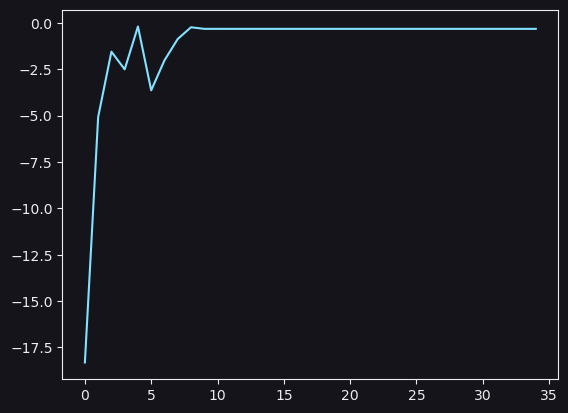

In [43]:
fname = "run4.pickle"
with open(fname, "rb") as handle:
    rd = pickle.load(handle)
plt.plot(rd["total_ll"])

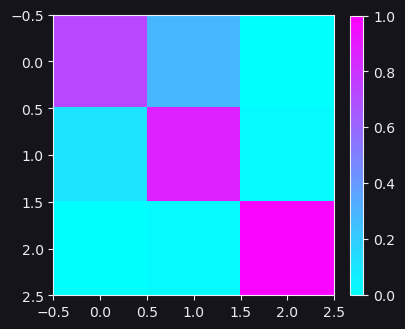

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(np.exp(rd["T"]), cmap="cool", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, fraction=0.045)

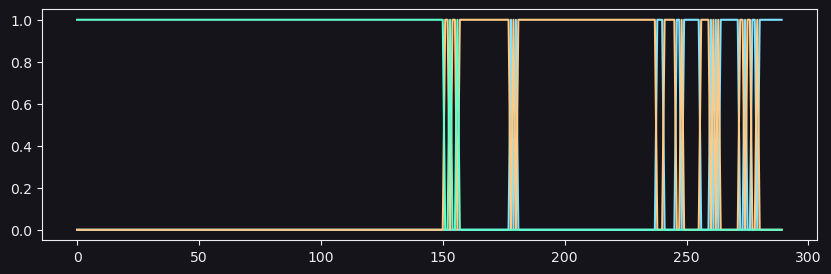

In [45]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.exp(rd["gamma"].T))

[172  47 117 192 323 251 195   9 211 277 242 292  87  70  88 314 193  39
  87 174  88 165  25  72 265 115 243 197  99 177 243 285 147 147 288 265
 185 127  32  31 202 244 151 163 183  28 290 128 128  53]


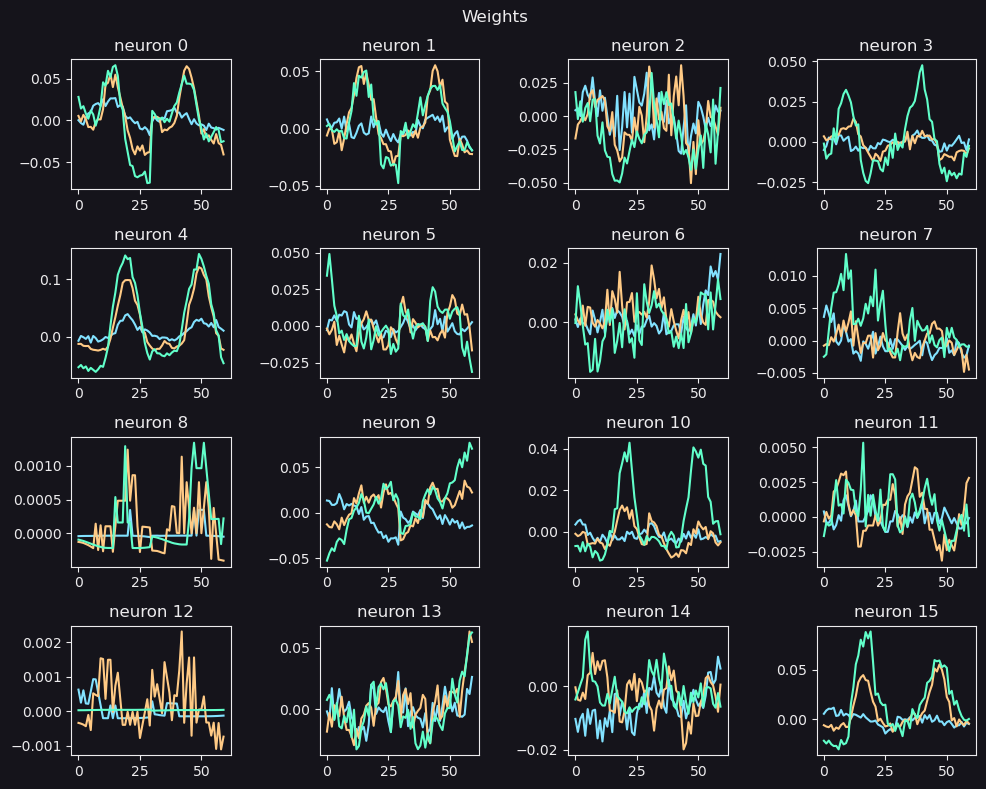

In [46]:
fig, axs = plt.subplots(4, 4, figsize=(10, 8))

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.plot(rd['theta'][:, :-1, i].T)
    ax.set_title(f"neuron {i}")
plt.suptitle("Weights")
plt.tight_layout()
print(rd['neuron_idx'])

gamma for selected trial [0.00000000e+000 3.79437816e-155 1.00000000e+000]


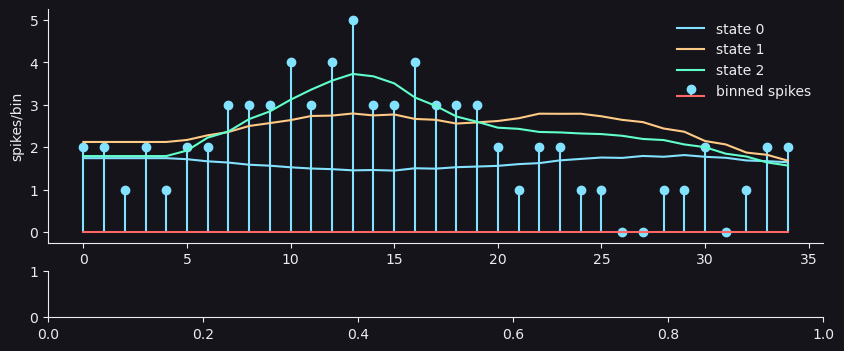

In [48]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})

sort_idx = np.argsort(
    data["nCues_RminusL"]
)  # ordered index of (lots of left cues) -> (lots of right cues)
plot_trial = sort_idx[1]
neuron = 9
X_plot = X_all[neuron, trial_id == plot_trial]
# y_pred = np.exp(X_plot @ theta_init[:, neuron])
y_pred = np.exp(X_plot @ rd['theta'][:, :, neuron].T)

# y_pred = np.exp(X_plot @ theta_post[:, :, neuron].T)

y_plot = y_all[neuron, trial_id == plot_trial]
axs[0].stem(y_plot, label="binned spikes")
axs[0].plot(y_pred, label=[f"state {i}" for i in range(n_states)])
# trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel("spikes/bin")
axs[0].legend()


# axs[1].plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
# axs[1].plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
# trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
# axs[1].set_ylabel("# of towers")
# axs[1].set_title("Binned Stimulus")
# axs[1].legend()
# plt.tight_layout()
sns.despine()
print(f"gamma for selected trial {np.exp(rd['gamma'][:, plot_trial])}")

Spike history of other neurons to determine current neuron activity? Seems like a reasonable feature in a connected network

## Questions
- is it an issue that gamma almost always equals 1 or 0
- should the total ll of the model just be the sum of gamma * ll


## To-do
- try without spike history
